对应`tf.kears` 版本的03，在训练过程中加入更多的控制

1. 训练中保存/保存最好的模型
2. 早停
3. 训练过程可视化

<font color="red">注</font>: 使用 tensorboard 可视化需要安装 tensorflow (TensorBoard依赖于tensorflow库，可以任意安装tensorflow的gpu/cpu版本)

```shell
pip install tensorflow
```

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)  #设备是cuda:0，即GPU，如果没有GPU则是cpu


sys.version_info(major=3, minor=11, micro=11, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.2
sklearn 1.6.0
torch 2.5.1+cu121
cuda:0


## 数据准备

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# fashion_mnist图像分类数据集
train_ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_ds = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 当然也可以用 torch.utils.data.Dataset 实现人为划分

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.6MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 173kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.20MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 23.2MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
# 从数据集到dataloader
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

In [4]:
# 查看数据
for datas, labels in train_loader:
    print(datas.shape)
    print(labels.shape)
    break
#查看val_loader
for datas, labels in val_loader:
    print(datas.shape)
    print(labels.shape)
    break

torch.Size([32, 1, 28, 28])
torch.Size([32])
torch.Size([32, 1, 28, 28])
torch.Size([32])


## 定义模型

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 300),  # in_features=784, out_features=300
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        # x.shape [batch size, 1, 28, 28]
        x = self.flatten(x)
        # 展平后 x.shape [batch size, 28 * 28]
        logits = self.linear_relu_stack(x)
        # logits.shape [batch size, 10]
        return logits

model = NeuralNetwork()

## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [6]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        #datas.shape [batch size, 1, 28, 28]
        #labels.shape [batch size]
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item()) # tensor.item() 获取tensor的数值，loss是只有一个元素的tensor

        preds = logits.argmax(axis=-1)    # 验证集预测, axis=-1 表示最后一个维度,因为logits.shape [batch size, 10]，所以axis=-1表示对最后一个维度求argmax，即对每个样本的10个类别的概率求argmax，得到最大概率的类别, preds.shape [batch size]
        pred_list.extend(preds.cpu().numpy().tolist()) # tensor转numpy，再转list
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list) # 验证集准确率
    return np.mean(loss_list), acc # 返回验证集平均损失和准确率


# TensorBoard 可视化

pip install tensorboard
训练过程中可以使用如下命令启动tensorboard服务。注意使用绝对路径，否则会报错

```shell
 tensorboard  --logdir="D:\BaiduSyncdisk\pytorch\chapter_2_torch\runs" --host 0.0.0.0 --port 8848
```

In [7]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs) # 实例化SummaryWriter, log_dir是log存放路径，flush_secs是每隔多少秒写入磁盘

    def draw_model(self, model, input_shape):#graphs
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape)) # 画模型图

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            ) # 画loss曲线, main_tag是主tag，tag_scalar_dict是子tag，global_step是步数

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        ) # 画acc曲线, main_tag是主tag，tag_scalar_dict是子tag，global_step是步数

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,
        ) # 画lr曲线, main_tag是主tag，tag_scalar_dict是子tag，global_step是步数

    def __call__(self, step, **kwargs):
        # add loss,把loss，val_loss取掉，画loss曲线
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss) # 画loss曲线
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc) # 画acc曲线
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate) # 画lr曲线


### Save Best


In [8]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=500, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch.
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir # 保存路径
        self.save_step = save_step # 保存步数
        self.save_best_only = save_best_only # 是否只保存最好的模型
        self.best_metrics = -1 # 最好的指标，指标不可能为负数，所以初始化为-1

        # mkdir
        if not os.path.exists(self.save_dir): # 如果不存在保存路径，则创建
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0: #每隔save_step步保存一次
            return

        if self.save_best_only:
            assert metric is not None # 必须传入metric
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt")) # 保存最好的模型，覆盖之前的模型，不保存step，只保存state_dict，即模型参数，不保存优化器参数
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt")) # 保存每个step的模型，不覆盖之前的模型，保存step，保存state_dict，即模型参数，不保存优化器参数



### Early Stop

In [9]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience # 多少个epoch没有提升就停止训练
        self.min_delta = min_delta # 最小的提升幅度
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:#用准确率
            # update best metric
            self.best_metric = metric
            # reset counter
            self.counter = 0
        else:
            self.counter += 1 # 计数器加1，下面的patience判断用到

    @property
    def early_stop(self):
        return self.counter >= self.patience


In [ ]:
500*32*5

80000

In [10]:
# 训练
def training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device) # 数据放到device上
                labels = labels.to(device) # 标签放到device上
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传，计算梯度，更新参数，这里是更新模型参数
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()  # 切换到验证集模式
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train() # 切换回训练集模式

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"], # 取出当前学习率
                            )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc) # 保存最好的模型，覆盖之前的模型，保存step，保存state_dict,通过metric判断是否保存最好的模型

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc) # 验证集准确率不再提升，则停止训练
                        if early_stop_callback.early_stop:# 验证集准确率不再提升，则停止训练
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict

In [12]:
epoch = 100

model = NeuralNetwork()

# 1. 定义损失函数 采用MSE损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 1. tensorboard 可视化
tensorboard_callback = TensorBoardCallback("runs")
tensorboard_callback.draw_model(model, [1, 28, 28])
# 2. save best
save_ckpt_callback = SaveCheckpointsCallback("checkpoints", save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10)


In [ ]:
list(model.parameters())[1] #可学习的模型参数

Parameter containing:
tensor([ 8.8742e-03,  5.1779e-03, -2.5233e-02, -1.9432e-02, -2.6992e-02,
        -1.0262e-02, -9.9559e-03, -2.8894e-02, -7.3424e-03,  2.4227e-04,
         3.4269e-03,  1.6518e-02,  1.7700e-02, -3.5169e-02, -2.9928e-02,
         3.0644e-02,  3.0822e-02, -1.6215e-02, -2.8830e-02, -3.4676e-02,
         8.5081e-03,  4.6115e-03,  2.2893e-02,  2.2112e-04, -1.7842e-02,
         2.7805e-03, -7.4717e-03,  1.9765e-02,  2.4835e-02,  3.3089e-02,
        -2.8166e-02,  3.3634e-02, -3.3583e-02, -2.3294e-02, -3.2217e-02,
        -3.4792e-02, -1.8947e-02, -1.6239e-02,  3.0975e-02, -2.0176e-02,
        -1.1199e-02,  2.2809e-02, -1.6708e-02,  1.1415e-03,  9.1366e-03,
        -3.3974e-02,  1.1891e-02,  5.6981e-03,  1.7544e-02, -2.9667e-03,
        -1.3368e-02,  8.2697e-03,  2.4605e-02, -6.6776e-03, -6.5502e-03,
        -5.7296e-03, -1.6775e-02,  2.3113e-02,  3.2304e-02, -5.5061e-03,
        -2.1324e-02, -3.2872e-02, -2.0915e-02,  3.7288e-03, -1.8517e-02,
        -1.0835e-02,  1.4550e

In [13]:
model.state_dict().keys()

odict_keys(['linear_relu_stack.0.weight', 'linear_relu_stack.0.bias', 'linear_relu_stack.2.weight', 'linear_relu_stack.2.bias', 'linear_relu_stack.4.weight', 'linear_relu_stack.4.bias'])

In [14]:
model = model.to(device)
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=1000
    )

  0%|          | 0/187500 [00:00<?, ?it/s]

Early stop at epoch 14 / global_step 27000


In [15]:
#帮我写个enumerate例子
for i, item in enumerate(["a", "b", "c"]):
    print(i, item)

0 a
1 b
2 c


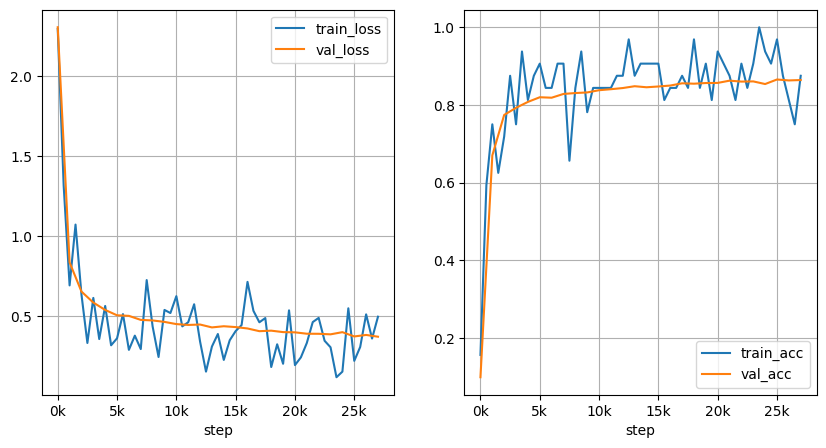

In [16]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns) #因为有loss和acc两个指标，所以画个子图
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5)) #fig_num个子图，figsize是子图大小
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        x_data=range(0, train_df.index[-1], 5000) #每隔5000步标出一个点
        axs[idx].set_xticks(x_data)
        axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", x_data)) #map生成labal
        axs[idx].set_xlabel("step")

    plt.show()

plot_learning_curves(record, sample_step=500)  #横坐标是 steps

# 评估

In [17]:
model = NeuralNetwork() #上线时加载模型
model = model.to(device)

In [1]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/best.ckpt", weights_only=True,map_location="cpu"))

model.eval()
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

NameError: name 'model' is not defined